##Import Libraries

In [26]:
import matplotlib.pyplot as plt
import PIL
from torchvision import transforms, datasets, models
from torchvision.datasets.utils import download_and_extract_archive
import os
import urllib.request
import hashlib
import torch
import torchvision.datasets.utils as utils
import tarfile
from pathlib import Path
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
import cv2
import numpy as np

##Data Collection

In [2]:
def get_file(url, dest_path, md5=None):
    if os.path.exists(dest_path):
        print(f"File already exists at {dest_path}")
    else:
        print(f"Downloading {url}...")
        urllib.request.urlretrieve(url, dest_path)

    if md5 is not None:
        assert hashlib.md5(open(dest_path, 'rb').read()).hexdigest() == md5, f"Checksum mismatch for {dest_path}"

# URL of the file to be downloaded
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Destination path to save the downloaded file
dest_path = "./flower_photos.tgz"

# Download the file using the get_file function
get_file(url, dest_path)
data_dir = "./flower_photos"  # Destination path to extract the contents
with tarfile.open(dest_path, 'r:gz') as tar:
    tar.extractall(path=data_dir)

In [3]:
data_dir = Path(data_dir)
data_dir = data_dir / 'flower_photos'
contents = list(data_dir.iterdir())
daisy_folder = data_dir / 'daisy'
daisy_images = list(daisy_folder.glob('*jpg'))

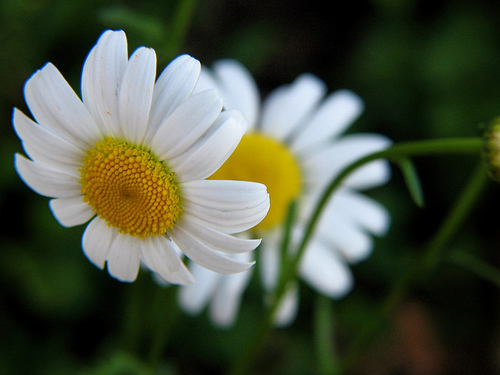

In [4]:
PIL.Image.open(str(daisy_images[-1]))

## Data Preprocessing

In [5]:
#apply transformation to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),       # Resize the image to a fixed size (you can adjust as needed)
    transforms.RandomCrop((224, 224)),   # Randomly crop the image to the desired size for data augmentation
    transforms.RandomHorizontalFlip(),   # Randomly flip the image horizontally for data augmentation
    transforms.ToTensor(),               # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

dataset = datasets.ImageFolder(data_dir,transform)
num_samples = len(dataset)
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size,test_size])

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
class_names = dataset.classes
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


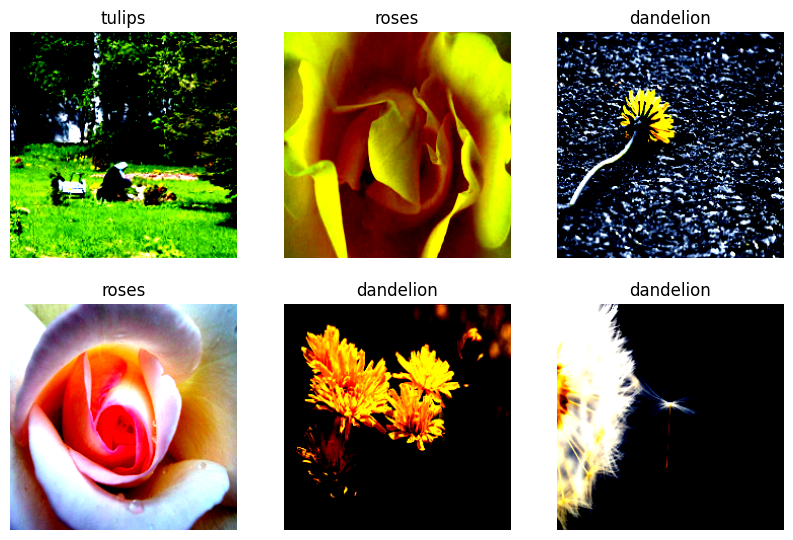

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataloader:
    for i in range(6):  # Visualize 6 samples
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().transpose(1, 2, 0))  # Transpose tensor to (H, W, C) for visualization
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break  # Only visualize the first batch of the training dataset

plt.show()

##Training Data

In [9]:
resnet_model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 341MB/s]


In [10]:
for param in resnet_model.parameters():
    param.requires_grad = False
num_features = resnet_model.fc.in_features
custom_classifier = nn.Sequential(
    nn.Flatten(),
    nn.ReLU(),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Linear(512, 5),  # 5 classes
    nn.Softmax(dim=1)  # Apply softmax along the specified dimension (dim=1 for batch dimension)
)
resnet_model.fc = custom_classifier

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(resnet_model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [12]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification, use CrossEntropyLoss
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
epochs = 10

train_loss_history = []
validation_loss_history = []
train_accuracy_history = []
validation_accuracy_history = []

for epoch in range(epochs):
    resnet_model.train()  # Set the model to training mode

    train_loss = 0.0
    train_corrects = 0

    for inputs, labels in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = resnet_model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimizer update
        loss.backward()
        optimizer.step()

        # Update training loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data).item()

    # Calculate average training loss and accuracy for the epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    train_accuracy = train_corrects / len(train_dataloader.dataset)

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation loop
    resnet_model.eval()  # Set the model to evaluation mode

    validation_loss = 0.0
    validation_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader, desc=f'Validation Epoch {epoch + 1}/{epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            _, preds = torch.max(outputs, 1)
            validation_corrects += torch.sum(preds == labels.data).item()

    # Calculate average validation loss and accuracy for the epoch
    validation_loss = validation_loss / len(test_dataloader.dataset)
    validation_accuracy = validation_corrects / len(test_dataloader.dataset)

    validation_loss_history.append(validation_loss)
    validation_accuracy_history.append(validation_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}: Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')

Epoch 1/10:   0%|          | 0/92 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1/10: 100%|██████████| 92/92 [13:19<00:00,  8.69s/it]


Epoch 1/10: Train Loss: 0.9865, Train Accuracy: 0.9162


Validation Epoch 1/10: 100%|██████████| 23/23 [02:50<00:00,  7.40s/it]


Epoch 1/10: Validation Loss: 1.0247, Validation Accuracy: 0.8760


Epoch 2/10: 100%|██████████| 92/92 [13:17<00:00,  8.67s/it]


Epoch 2/10: Train Loss: 0.9739, Train Accuracy: 0.9302


Validation Epoch 2/10: 100%|██████████| 23/23 [02:53<00:00,  7.54s/it]


Epoch 2/10: Validation Loss: 1.0322, Validation Accuracy: 0.8678


Epoch 3/10: 100%|██████████| 92/92 [13:18<00:00,  8.68s/it]


Epoch 3/10: Train Loss: 0.9840, Train Accuracy: 0.9206


Validation Epoch 3/10: 100%|██████████| 23/23 [02:49<00:00,  7.36s/it]


Epoch 3/10: Validation Loss: 1.0121, Validation Accuracy: 0.8924


Epoch 4/10: 100%|██████████| 92/92 [13:12<00:00,  8.61s/it]


Epoch 4/10: Train Loss: 0.9866, Train Accuracy: 0.9179


Validation Epoch 4/10: 100%|██████████| 23/23 [02:52<00:00,  7.48s/it]


Epoch 4/10: Validation Loss: 1.0217, Validation Accuracy: 0.8815


Epoch 5/10: 100%|██████████| 92/92 [13:19<00:00,  8.69s/it]


Epoch 5/10: Train Loss: 0.9806, Train Accuracy: 0.9240


Validation Epoch 5/10: 100%|██████████| 23/23 [02:52<00:00,  7.50s/it]


Epoch 5/10: Validation Loss: 1.0196, Validation Accuracy: 0.8815


Epoch 6/10: 100%|██████████| 92/92 [13:13<00:00,  8.63s/it]


Epoch 6/10: Train Loss: 0.9906, Train Accuracy: 0.9128


Validation Epoch 6/10: 100%|██████████| 23/23 [02:52<00:00,  7.52s/it]


Epoch 6/10: Validation Loss: 1.0158, Validation Accuracy: 0.8856


Epoch 7/10: 100%|██████████| 92/92 [13:16<00:00,  8.66s/it]


Epoch 7/10: Train Loss: 0.9832, Train Accuracy: 0.9234


Validation Epoch 7/10: 100%|██████████| 23/23 [02:51<00:00,  7.48s/it]


Epoch 7/10: Validation Loss: 1.0193, Validation Accuracy: 0.8869


Epoch 8/10: 100%|██████████| 92/92 [13:13<00:00,  8.63s/it]


Epoch 8/10: Train Loss: 0.9746, Train Accuracy: 0.9298


Validation Epoch 8/10: 100%|██████████| 23/23 [02:51<00:00,  7.45s/it]


Epoch 8/10: Validation Loss: 1.0059, Validation Accuracy: 0.8978


Epoch 9/10: 100%|██████████| 92/92 [13:12<00:00,  8.61s/it]


Epoch 9/10: Train Loss: 0.9777, Train Accuracy: 0.9268


Validation Epoch 9/10: 100%|██████████| 23/23 [02:49<00:00,  7.39s/it]


Epoch 9/10: Validation Loss: 1.0111, Validation Accuracy: 0.8910


Epoch 10/10: 100%|██████████| 92/92 [13:09<00:00,  8.59s/it]


Epoch 10/10: Train Loss: 0.9830, Train Accuracy: 0.9203


Validation Epoch 10/10: 100%|██████████| 23/23 [02:50<00:00,  7.43s/it]

Epoch 10/10: Validation Loss: 1.0208, Validation Accuracy: 0.8869


##Model Evaluation

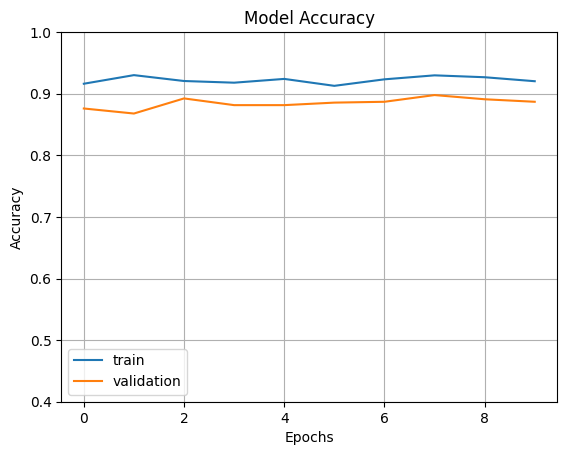

In [21]:
plt.plot(train_accuracy_history)
plt.plot(validation_accuracy_history)
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

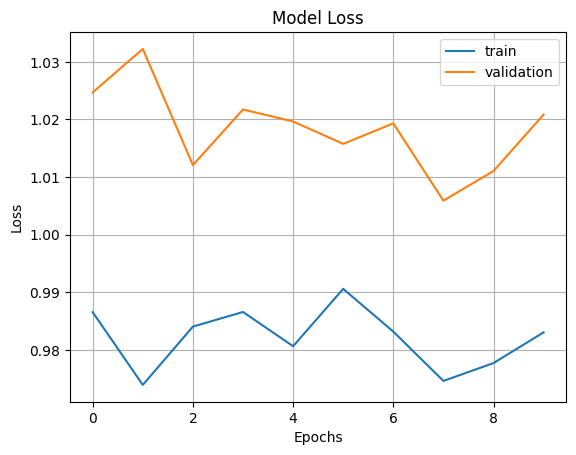

In [22]:
plt.plot(train_loss_history)
plt.plot(validation_loss_history)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

##Prediction

In [36]:
image_path = str(daisy_images[0])
image = cv2.imread(image_path)
image_resized = cv2.resize(image, (224, 224))  # Resize to match the input size of ResNet (224x224)
image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Define the transformation to normalize the image
transform = transforms.Compose([
    transforms.ToTensor(),                             # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # Normalize the image with the mean and std used during training
                         std=[0.229, 0.224, 0.225]),
])

# Apply the transformation
input_image_tensor = transform(image_resized)         # The shape will be [3, 224, 224]

# Add batch dimension to the input tensor
input_image_tensor = input_image_tensor.unsqueeze(0)  # The shape becomes [1, 3, 224, 224]

# Move the input tensor to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_image_tensor = input_image_tensor.to(device)

# Set the model to evaluation mode
resnet_model.eval()

# Perform inference
with torch.no_grad():
    outputs = resnet_model(input_image_tensor)

# Get the predicted class index (index with the highest probability)
_, predicted_class = torch.max(outputs, 1)

In [37]:
# Assuming you have a list 'class_names' that contains the names of the classes
predicted_class_name = class_names[predicted_class.item()]
print(f"Predicted Class: {predicted_class_name}")

Predicted Class: daisy
